# Exploratory Data Analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them. 

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Opening JSON file
f = open('logins.json')
data = json.load(f)

In [8]:
df=pd.DataFrame.from_dict(data)
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   login_time  93142 non-null  object
dtypes: object(1)
memory usage: 727.8+ KB


In [10]:
df.describe()

,login_time
count,93142
unique,92265
top,1970-03-29 03:24:57
freq,3


In [11]:
print('The data contain %d logins from %s to %s' % (df.shape[0], min(df.login_time), max(df.login_time)))

The data contain 93142 logins from 1970-01-01 20:12:16 to 1970-04-13 18:57:38


In [12]:
#Aggregate these login counts based on 15minute time intervals

In [13]:
df['login_time']=pd.to_datetime(df['login_time'])
type(df.login_time[1])

pandas._libs.tslibs.timestamps.Timestamp

In [14]:
#group date by 15 min intervals and count
login_counts=df.resample('15min', on='login_time').count()

In [15]:
login_counts.columns=['count']

### Plot resampled time series

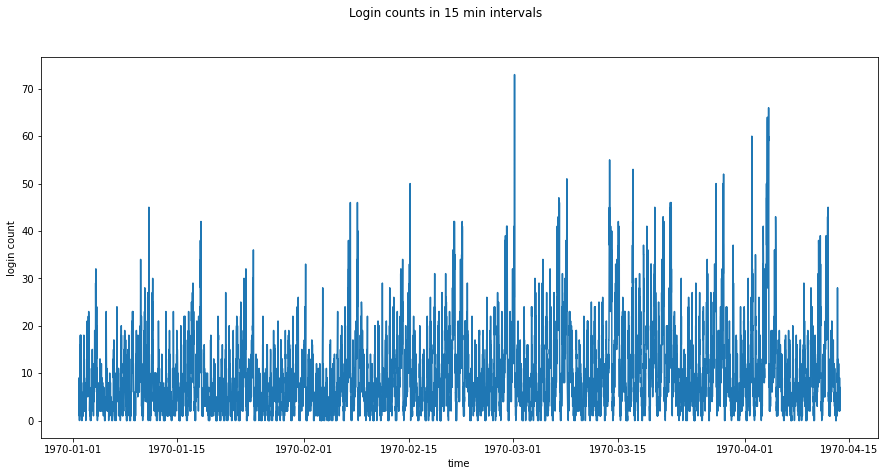

In [17]:
fig = plt.figure(figsize=(15,7))
plt.plot(login_counts)
fig.suptitle('Login counts in 15 min intervals')
plt.xlabel('time')
plt.ylabel('login count')
None

### Decompose weekly and daily seasonality

In [52]:
#decompose daily and weekly seasonality
import statsmodels.api as sm
from matplotlib import rcParams
raw_series=login_counts
daily_components = sm.tsa.seasonal_decompose(raw_series, period=int(24*60/15))
weekly_components= sm.tsa.seasonal_decompose(raw_series, period=int(24*60/15*7))
monthly_components= sm.tsa.seasonal_decompose(raw_series, period=int(24*60/15*30))
adjusted =daily_components.observed- daily_components.seasonal - weekly_components.seasonal - monthly_components.seasonal


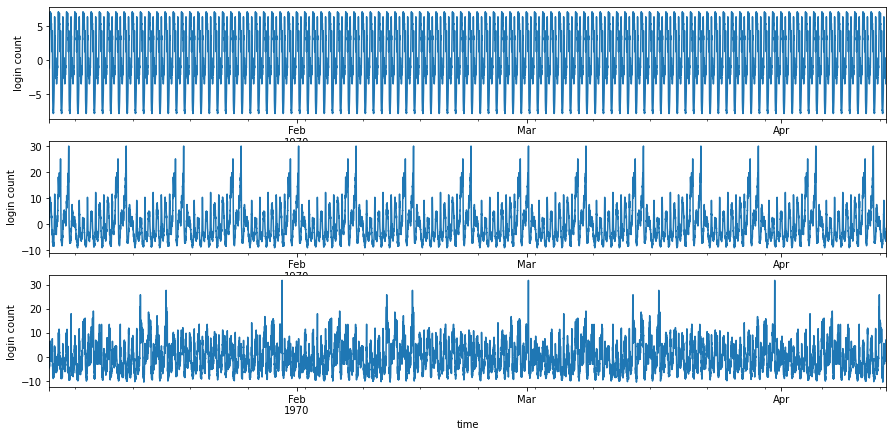

In [53]:
#DAILY AND WEEKLY SEASONALITY

#get daily seasonality 

plt.subplot(3, 1, 1)
daily_components.seasonal.plot(figsize=(15,7))
fig.suptitle('Daily seasonality')
plt.xlabel('time')
plt.ylabel('login count')

#get weekly seasonality
plt.subplot(3, 1, 2)
weekly_components.seasonal.plot(figsize=(15,7))
fig.suptitle('Weekly seasonality')
plt.xlabel('time')
plt.ylabel('login count')


#get monthly seasonality
plt.subplot(3, 1, 3)
monthly_components.seasonal.plot(figsize=(15,7))
fig.suptitle('Monthly seasonality')
plt.xlabel('time')
plt.ylabel('login count')
None

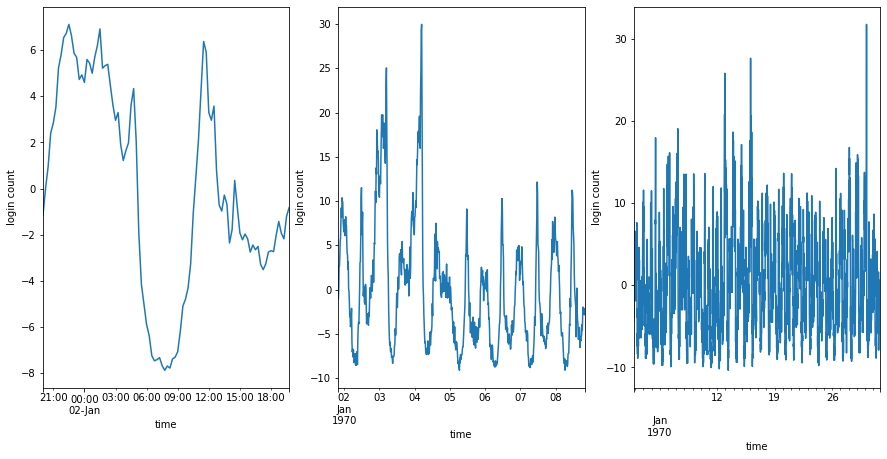

In [54]:
#get seasonality for one day

plt.subplot(1, 3, 1)
day=daily_components.seasonal[0:int((60*24/15))]
day.plot(figsize=(15,7))
fig.suptitle('Daily seasonality')
plt.xlabel('time')
plt.ylabel('login count')

#get seasonality for one week
plt.subplot(1, 3, 2)
week=weekly_components.seasonal[0:int((60*24/15)*7)]
week.plot(figsize=(15,7))
fig.suptitle('Weekly seasonality')
plt.xlabel('time')
plt.ylabel('login count')

#get seasonality for one month

plt.subplot(1, 3,3)
month=monthly_components.seasonal[0:int((60*24/15)*30)]
month.plot(figsize=(15,7))
fig.suptitle('Month seasonality')
plt.xlabel('time')
plt.ylabel('login count')
None

The daily seasonality chart on the left suggests that traffic is highest between around 10 p.m. and 4 a.m. and between 10 a.m and 12 a.m. 
The weekly seasonality chart on the right suggests that on the 3rd and 4th of January the peaks of traffic are higher than on the other days of the week. This could reflect the weekend. Therefore we will explore weekdays vs. weekends next.
The monthly seasonality decomposition suggests that there are peaks in logins the middle and end of the month.

### Seasonality by weekday

In [19]:
#get seasonality for weekdays
start_w=int((60*24/15))*4-20*4
end_w=start_w+int((60*24/15))*5
weekdays=weekly_components.seasonal[start_w:end_w]
#get seasonality for weekends
start_we=int((60*24/15))+4*4
end_we=start_we+int((60*24/15))*2
weekends=weekly_components.seasonal[start_we:end_we]


In [20]:
weekend_time=pd.DataFrame(weekends).reset_index()
weekday_time=pd.DataFrame(weekdays).reset_index()

In [21]:
weekend_time=weekend_time.resample("6h", on='login_time').count()['login_time'].reset_index(name='count')
weekday_time=weekday_time.resample("24h", on='login_time').count()['login_time'].reset_index(name='count')

In [22]:
# make x tick labels including the weekday
weekend_time['day']=weekend_time['login_time'].dt.day_name() 
weekday_time['day']=weekday_time['login_time'].dt.day_name()

In [23]:
weekend_labels=[str(date.strftime("%H:%M"))+" " +str(day) for date, day in zip(weekend_time['login_time'], weekend_time['day'])]
weekday_labels=[str(date.strftime("%H:%M"))+" "+str(day) for date, day in zip(weekday_time['login_time'], weekday_time['day'])]

<ipython-input-60-f3add286fd52>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(weekday_labels)


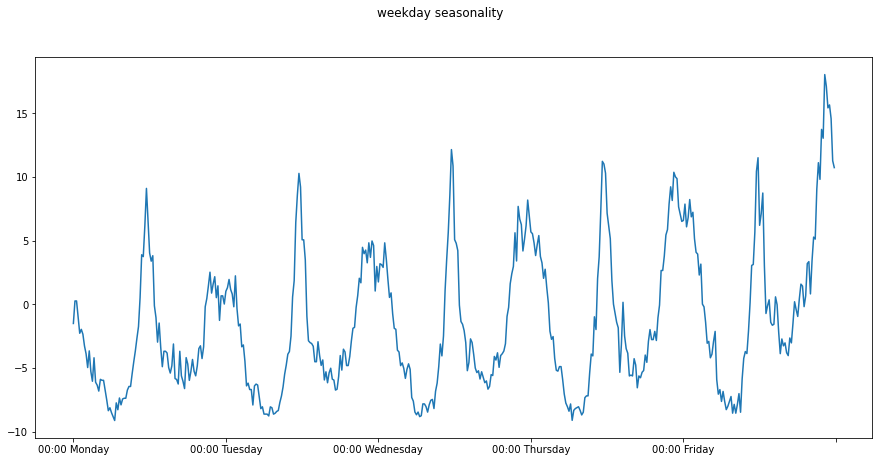

In [60]:
fig, ax = plt.subplots(figsize=(15,7))
x = weekdays.index
y = weekdays

ax.plot(x,y)



ax.set_xticklabels(weekday_labels)
fig.suptitle('weekday seasonality')



None

During the week, the traffic is highest around 10 p.m. and 1 a.m. and there is a peak at around 12 p.m. every day. There also is a positive trend across the week (traffic increases).
There are two phases of low traffic, in the mornings (around 6 a.m.) and (3 p.m. to 9 p.m.).

<ipython-input-32-3b57f19e8b2d>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(weekend_labels)


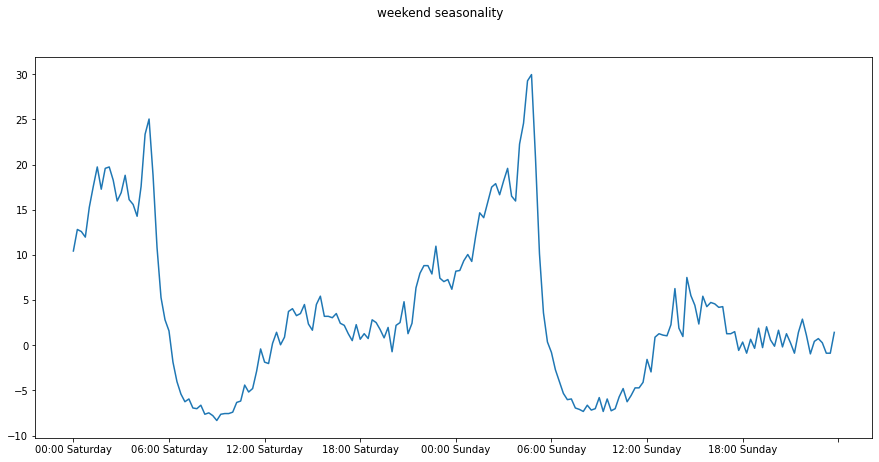

<Figure size 1080x720 with 0 Axes>

In [32]:
#weekend
fig, ax = plt.subplots(figsize=(15,7))
x = weekends.index
y = weekends
ax.plot(x,y)
ax.set_xticklabels(weekend_labels)
fig.suptitle('weekend seasonality')
plt.figure(figsize=(15,10))
None

One weekends, traffic low in the morinings (6-9 a.m.), more or less constant during the day (10 a.m. till 10 p.m.) and then increases a until a peak at 5 a.m. and then drops. There is only one peak per day.

### Trend analysis

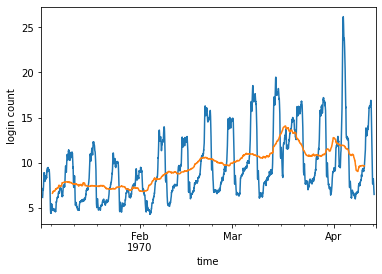

In [50]:
#Trends
daily_components.trend.plot()
weekly_components.trend.plot()

fig.suptitle('Daily and weekly trends')
plt.xlabel('time')
plt.ylabel('login count')
None

After subtracting the weekly and daily seasonality, there is a positive trend in logins across time.

### Login count by weekday

In [65]:
#make barplot by weekdays
#count logins per day
daily=df.resample('1D', on='login_time').count()
daily.columns=['count']
daily.reset_index(inplace=True)
daily['day'] = daily['login_time'].dt.day_name()


In [66]:
wd=pd.DataFrame(daily['count'].groupby(daily['day']).mean())

In [67]:
wd.reset_index(inplace=True)

Text(0, 0.5, 'Value')

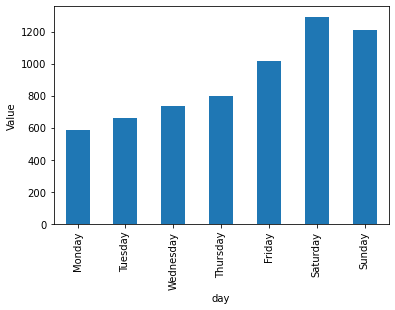

In [68]:
field = "day"
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
ax = wd.set_index(field).loc[day_order].plot(kind="bar", legend=False)
ax.set_ylabel("Value")